# Latihan lattice

In [1]:
import openmc

In [2]:
Plutonium_nitrate = openmc.Material(name="Plutonium Nitrate")
Plutonium_nitrate.add_nuclide("Pu239", 2.7682E-4)
Plutonium_nitrate.add_nuclide("Pu240", 1.2214E-5)
Plutonium_nitrate.add_nuclide("Pu241", 8.3390E-7)
Plutonium_nitrate.add_nuclide("Pu242", 4.5800E-8)
Plutonium_nitrate.add_element("H", 6.0070E-2)
Plutonium_nitrate.add_element("O", 3.6540E-2)
Plutonium_nitrate.add_element("N", 2.3699E-3)
Plutonium_nitrate.add_s_alpha_beta("c_H_in_H2O")
Plutonium_nitrate.set_density("sum", 9.9270E-2)

Stainless_steel = openmc.Material(name="Stainless Steel")
Stainless_steel.add_element("Fe", 6.3310E-2)
Stainless_steel.add_element("Cr", 1.6540E-2)
Stainless_steel.add_element("Ni", 6.5100E-3)
Stainless_steel.set_density("sum", 8.6360E-2)

materials = openmc.Materials([Plutonium_nitrate, Stainless_steel])
materials.export_to_xml()

material_colors = {Plutonium_nitrate : 'red', Stainless_steel : 'black'}

/home/dhiyasalmas/miniconda3/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:494: UserWarning: Density "0.09927" for Material ID="1" is ignored because the unit is "sum"
  warnings.warn(msg)
/home/dhiyasalmas/miniconda3/envs/openmc-env/lib/python3.11/site-packages/openmc/material.py:494: UserWarning: Density "0.08636" for Material ID="2" is ignored because the unit is "sum"
  warnings.warn(msg)


In [73]:
#Bahan Bakar
inner_diameter = 24.98
tank_thickness = 0.6
Jari_jari_plutoniumnitrate = inner_diameter/2
Jari_jari_SS = (inner_diameter+2*tank_thickness)/2
Panjang_plutoniumnitrate = 39.24
Panjang_SS = 101.70
surface_separation = 10
pitch = surface_separation+inner_diameter+2*tank_thickness

Plutonium_silinder = openmc.ZCylinder(r=Jari_jari_plutoniumnitrate)
SS_silinder = openmc.ZCylinder(r=Jari_jari_SS)
t_Pu = openmc.ZPlane(z0=-((Panjang_SS-1)/2-Panjang_plutoniumnitrate))
b_Pu = openmc.ZPlane(z0=-(Panjang_SS-1)/2)
t_SS = openmc.ZPlane(z0=Panjang_SS/2)
b_SS = openmc.ZPlane(z0=-Panjang_SS/2)
t_SSalas = openmc.ZPlane(z0=-Panjang_SS/2+1, boundary_type='vacuum')
b_SSalas = openmc.ZPlane(z0=-Panjang_SS/2, boundary_type='vacuum')
t_SStutup = openmc.ZPlane(z0=Panjang_SS/2+1, boundary_type='vacuum')
b_SStutup = openmc.ZPlane(z0=Panjang_SS/2, boundary_type='vacuum')

#Kubus
boundary_width = ((inner_diameter+2*tank_thickness)*3+surface_separation*3)/2
boundary_length = ((inner_diameter+2*tank_thickness)*2+surface_separation*2)/2
boundary_height =  (Panjang_SS)/2
kiri = openmc.XPlane(x0=-boundary_width, boundary_type='vacuum')
kanan = openmc.XPlane(x0=boundary_width, boundary_type='vacuum')
depan = openmc.YPlane(y0=-boundary_length, boundary_type='vacuum')
belakang = openmc.YPlane(y0=boundary_length, boundary_type='vacuum')
bawah = openmc.ZPlane(z0=boundary_height, boundary_type='vacuum')
atas = openmc.ZPlane(z0=-boundary_height, boundary_type='vacuum')

kubus = +kiri & -kanan & +depan & -belakang & -bawah & +atas

Fuel = -Plutonium_silinder & -t_Pu & +b_Pu 
SS = +Plutonium_silinder & -SS_silinder & -t_SS & +b_SS | -SS_silinder & -t_SSalas & +b_SSalas | -SS_silinder & -t_SStutup & +b_SStutup
Void = -Plutonium_silinder & +t_Pu & -t_SS
Void_outter = +SS_silinder | -b_SS | +t_SS

# Cell bahan bakar dan clad
Fuel_cell = openmc.Cell(fill=Plutonium_nitrate, region=Fuel)
SS_cell = openmc.Cell(fill=Stainless_steel, region=SS)
Void1_cell = openmc.Cell(region=Void)
Void2_cell = openmc.Cell(region=Void_outter)

Plutonium_universe = openmc.Universe(cells=[Fuel_cell, SS_cell, Void1_cell, Void2_cell]) 

# Void di luar bahan bakar
Void_cell = openmc.Cell()
Void_universe = openmc.Universe(cells=[Void_cell])

# Lattice untuk 2 silinder bahan bakar
lattice = openmc.RectLattice()
lattice.lower_left = (-boundary_width, -boundary_length) #-panjang/2, -lebar/2
lattice.pitch = (pitch, pitch)
lattice.universes = [[Plutonium_universe, Plutonium_universe, Plutonium_universe], 
                     [Plutonium_universe, Plutonium_universe, Plutonium_universe]]
lattice.outer = Void_universe

Kubus_cell = openmc.Cell(fill=lattice, region=kubus)
kubus_universe = openmc.Universe(cells=[Kubus_cell])

geom = openmc.Geometry(kubus_universe)
geom.export_to_xml()

<Axes: xlabel='y [cm]', ylabel='z [cm]'>

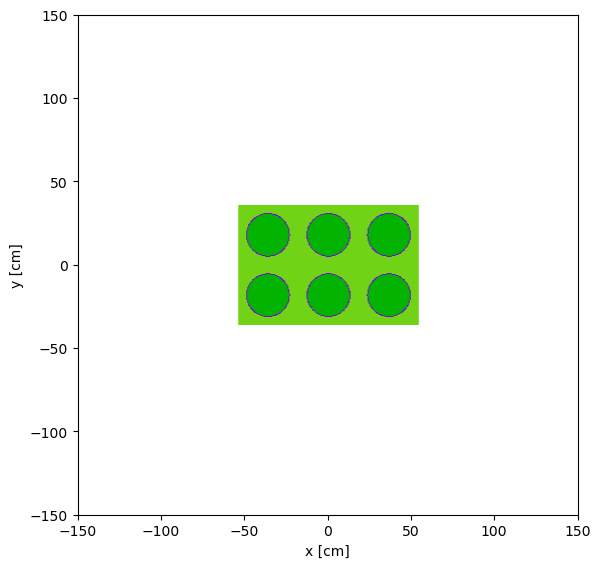

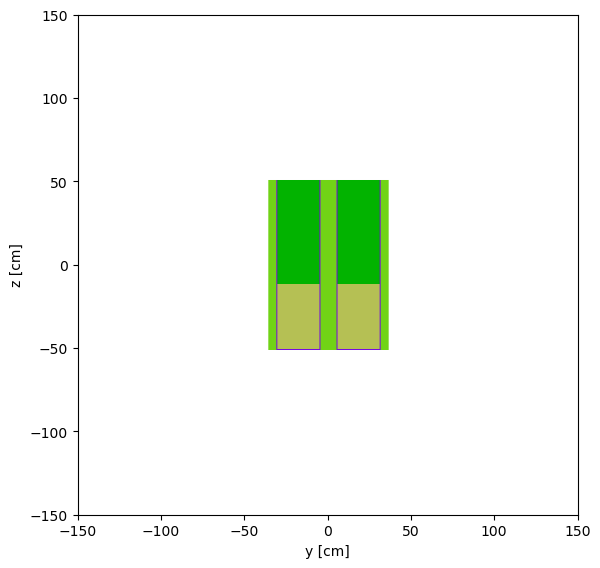

In [82]:
Kubus_cell.plot(basis='xy', width=(300,300), origin=(0,0,0), pixels=(500,500), color_by='cell')
Kubus_cell.plot(basis='yz', width=(300,300), origin=(0,0,0), pixels=(500,500), color_by='cell')

In [83]:
# Pengaturan simulasi
import openmc.statepoint
import openmc.stats

settings = openmc.Settings()
settings.particles = 100000       # Jumlah neutron per generasi
settings.inactive = 50            # Generasi yang diabaikan
settings.batches = 250            # Total generasi

koordinat = [[35.58,     -25.58, -19.62], [0,    30.58, -19.62], [-35.58,   25.58, -19.62],
             [-35.58,     -25.58, -19.62], [0,    -30.58, -19.62], [-35.58,   -25.58, -19.62]]
sources = {}

for i, pos in enumerate(koordinat):
    source = openmc.IndependentSource()
    source.space = openmc.stats.Point(pos)
    sources[f"source{i}"] = source
settings.source = list(sources.values())

settings.export_to_xml()
#!cat settings.xml

In [84]:
# Run the simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################